In [1]:
import torch
#from data import *
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from torch.optim import Adagrad
from torch.optim import Adam
from tqdm import tqdm_notebook
#from vae import *
#import argparse

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.gridspec as gridspec


In [2]:
HIDDEN=64
BATCH_SIZE=32
EPOCHS=15
LR=2e-3
LATENT=64


#specify the device
device="cuda:0"

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim=2):
        """
            @param input_dim: input dimension of the data
            @param hidden_dim: hidden dimension of the MLPs
            @param latent_dim: output dimension of MLPs
            @------------------@
            @return: None
        """
        super(VAE,self).__init__()
        self.en = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim,latent_dim)
        
        self.de = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )

        self.final_layer=nn.Sequential(
            nn.Linear(hidden_dim,input_dim),
        )

        
          
    def encode(self,x):
        #x = torch.flatten(x)
        res = self.en(x)
        mu = self.mu(res)
        log_var = self.var(res)
        
        return mu,log_var
            
    def decode(self,x):
        res = self.de(x)
        res = self.final_layer(res)
        return res
    def reparameterize(self,mu,log_var):
        epsilon = torch.normal(mu,torch.exp(0.5 * log_var))
        return mu + log_var * epsilon
    def forward(self,x):
        mu, log_var = self.encode(x)
        norm = self.reparameterize(mu,log_var)
        res = self.decode(norm)
        return (res, x, mu,log_var)



    def loss_fc(self,x,label,*args):
        (res, x, mu, log_var) = self.forward(x)
        recon_loss = F.mse_loss(res,label)
        KL_divergence = torch.mean(-0.5 * torch.sum((1 + log_var - mu**2 - torch.exp(log_var)),dim=1), dim=0)
        KL_divergence.required_grad = True
        loss = recon_loss + KL_divergence
        
        return dict({'loss': loss, 'recon_loss': recon_loss, 'kl_loss': KL_divergence})



    def generate(self,x):
        return self.forward(x)[0]


In [4]:
from scipy.io import loadmat

def get_minibatch(x,batch_size,device='cpu'):
    indices = torch.randperm(x.shape[0])[:batch_size]
    return x[indices].reshape(batch_size, -1).to(device)

# This is get_data fc for MNIST handwritten, below is for MNIST Fashion
"""
def get_data(path,nums=25000,device='cpu'):
    img_data = scipy.io.loadmat(path)["data"].T / 255.
    img_data = torch.Tensor(img_data)
    img_data = get_minibatch(img_data,nums)
    img_data = img_data.to(device)
    distri = torch.zeros(img_data.shape)
    
    print(f"Shape of a data point: {img_data.shape}")
    print(f"Example data {img_data[0:1].shape}")
    break_point = int(0.8*nums)
    return img_data[:break_point], img_data[:break_point]
"""
def get_data(path, nums=25000, device='cpu'):
    data = np.genfromtxt(path, delimiter=',')
    data = data[1:,1:] / 255.0
    data = torch.Tensor(data).to(device)
    data = get_minibatch(data,nums)
    return data

def add_noise(data, std=1/10.,device='cpu'):
    distri = torch.normal(torch.zeros(data.shape),torch.ones(data.shape) * std).to(device)
    #print(data.device)
    return data.to(device) + distri
    #print(distri)

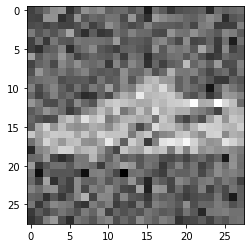

In [5]:
x = get_data("../Data/fashion.csv", nums=60000)


eval_data = get_data("../Data/fashion_eval.csv", nums=10000).to(device)
eval_data_full = (eval_data, add_noise(eval_data,std=1/4.,device=device))


t = add_noise(x,std=1/4.,device=device).cpu().detach().numpy()
plt.imshow(t[0].reshape(28,28),cmap="gray")

In [6]:
for k in eval_data_full: print(k.device)

cuda:0
cuda:0


In [7]:
def AEVB(data, eval_data, model, optimizer, input_dim, output_dim,epochs, batch_size):
    full_loss, kld, recon = [],[],[]
    efull_loss, ekld, erecon = [],[],[]
    for epc in range(epochs):
        fl,kl,rec = 0,0,0
        efl,ekl,erec = 0,0,0
        steps = x.shape[0] // batch_size
        for _ in tqdm_notebook(range(steps), desc='Epoch', leave=False):
            batch = get_minibatch(x,batch_size,device)
            batch_noise = add_noise(batch, std=1/45., device=device)
            optimizer.zero_grad()
 
            losses = model.loss_fc(batch_noise,batch)
            
            fl += losses["loss"].item() / batch_size
            kl += losses["kl_loss"].item() / batch_size
            rec += losses["recon_loss"].item() / batch_size
            losses["loss"].backward()
            optimizer.step()
            #for k in eval_data_full: print(k.device)
            elosses = model.loss_fc(eval_data_full[1],eval_data_full[0])  
            efl += elosses["loss"].item() / batch_size
            ekl += elosses["kl_loss"].item() / batch_size
            erec += elosses["recon_loss"].item() / batch_size
        #fl/= steps; kl /= steps; rec /= steps
        full_loss.append(fl); kld.append(kl); recon.append(rec)
        efull_loss.append(efl); ekld.append(ekl); erecon.append(erec)
        print(f"Epoch {epc + 1}\tFull loss: {full_loss[-1]}\trecon loss: {recon[-1]}\tkl_divergence: {kld[-1]}")
        
    return model, (full_loss, kld, recon),(efull_loss, ekld, erecon)





In [8]:
#Model 
model = VAE(x.shape[1],HIDDEN,LATENT).to(device)
# Optimizer

optimizer = Adam(model.parameters(), lr=LR)

In [9]:
(model, train_loss, eval_loss) = AEVB(data=x,
                                      eval_data=eval_data_full,
                                      model=model,
                                      optimizer=optimizer,
                                      input_dim=x.shape[1],
                                      output_dim=x.shape[1],
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS)

/tmp/ipykernel_207339/1706871134.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(steps), desc='Epoch', leave=False):


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1	Full loss: 5.321354032494128	recon loss: 2.588680803659372	kl_divergence: 2.732673239399446


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2	Full loss: 2.2652223127079196	recon loss: 1.808788567315787	kl_divergence: 0.4564337427727878


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3	Full loss: 1.7932899607694708	recon loss: 1.5821360700647347	kl_divergence: 0.21115389224723913


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4	Full loss: 1.4835107009857893	recon loss: 1.3959066797979176	kl_divergence: 0.08760401973268017


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5	Full loss: 1.3230806969222613	recon loss: 1.280589142057579	kl_divergence: 0.04249155573779717


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6	Full loss: 1.219893938570749	recon loss: 1.1892512035847176	kl_divergence: 0.030642734986031428


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7	Full loss: 1.1446814996015746	recon loss: 1.1193083132384345	kl_divergence: 0.025373186770593747


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8	Full loss: 1.0946269349078648	recon loss: 1.0714474304695614	kl_divergence: 0.023179504234576598


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9	Full loss: 1.0603926990006585	recon loss: 1.0380596923932899	kl_divergence: 0.022333006199914962


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10	Full loss: 1.019305065186927	recon loss: 0.997358973720111	kl_divergence: 0.02194609129219316


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11	Full loss: 0.9947791841404978	recon loss: 0.9731476047309116	kl_divergence: 0.02163157836184837


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12	Full loss: 0.9819841822318267	recon loss: 0.9610190406383481	kl_divergence: 0.020965141215128824


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13	Full loss: 0.9767493430699687	recon loss: 0.9555509296478704	kl_divergence: 0.021198414295213297


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14	Full loss: 0.9572728141502012	recon loss: 0.9372052090475336	kl_divergence: 0.020067605015356094


Epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15	Full loss: 0.9553877298894804	recon loss: 0.9355633278610185	kl_divergence: 0.019824402435915545


15


Text(0, 0.5, 'Losses')

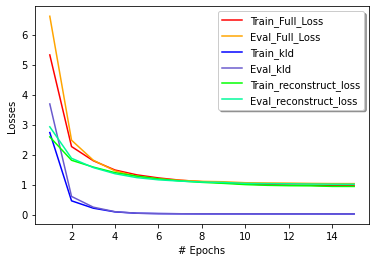

In [10]:
%matplotlib inline
print(len(train_loss[0]))

# Plot losses
plt.plot([i + 1 for i in range(len(train_loss[0]))], train_loss[0], color="red", label="Train_Full_Loss")
plt.plot([i + 1 for i in range(len(eval_loss[0]))], eval_loss[0], color="orange",label="Eval_Full_Loss")
plt.plot([i + 1 for i in range(len(train_loss[1]))], train_loss[1], color="blue",label="Train_kld")
plt.plot([i + 1 for i in range(len(eval_loss[1]))], eval_loss[1], color="slateblue",label="Eval_kld")
plt.plot([i + 1 for i in range(len(train_loss[2]))], train_loss[2], color="lime",label="Train_reconstruct_loss")
plt.plot([i + 1 for i in range(len(eval_loss[2]))], eval_loss[2], color="mediumspringgreen",label="Eval_reconstruct_loss")

# Legend

plt.legend(loc='upper right',shadow=True)


# Label
plt.xlabel("# Epochs")
plt.ylabel("Losses")


In [11]:
def visualization(x):
    kx = get_minibatch(x,25,device)
    kx = add_noise(kx, std=1/3., device=device)
    gen = model.generate(kx).cpu().detach().numpy()
    kx = kx.cpu().detach().numpy()
    

    fig, ax = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax[i-1,j-1].axis("off")
            tmp = kx[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax[i - 1,j - 1].imshow(tmp,cmap="gray")
    
    
    
    
    fig2, ax2 = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax2[i-1,j-1].axis("off")
            tmp = gen[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax2[i - 1,j - 1].imshow(tmp,cmap="gray")
    fig.show()
    fig2.show()

/tmp/ipykernel_207339/2716401791.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_207339/2716401791.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


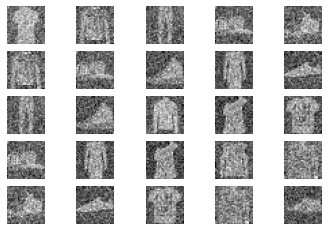

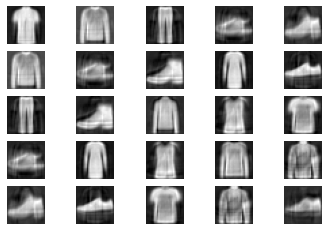

In [12]:
visualization(eval_data)